In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

Будем анализировать распределение показаний вольтметра 
при прохождении большого тока через металлический резистор. "Большой ток" - в том смысле, что нагрев резитора уменьшает его сопротивление и, за счет этого, ток возрастает нелинейно. 

$$ {I} = \frac {{U}} {{R} * (1 - \alpha T)} $$

Однако т.к. влияние температуры мало, закон Ома по-прежнему выполняется с досточноной точностью для применения линейной аппроксимации.





In [52]:
n_samples = 1000

temp = np.random.choice(100, n_samples)
voltage = np.random.choice(120, n_samples) + 15
resistance = np.random.choice(80, n_samples) + 10

current = voltage / resistance * (1 - temp*1e-6) * 1000

data = pd.DataFrame({'temp': temp, 'voltage': voltage, 'resistance': resistance, 'current': current})
data.head(5)

,temp,voltage,resistance,current
0,14,120,31,3870.913548
1,75,39,12,3249.756250
2,57,107,53,2018.752849
3,57,75,61,1229.438115
4,48,132,78,1692.226462


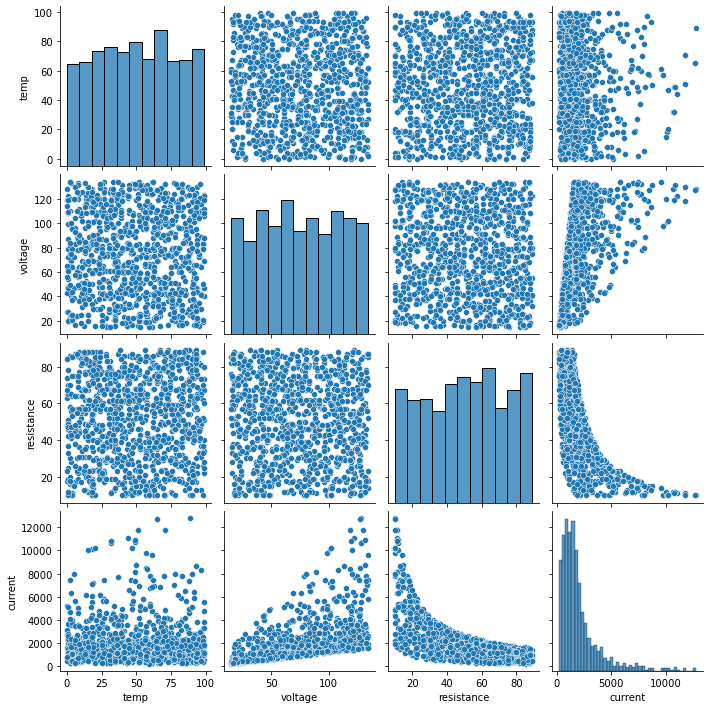

In [53]:
sns.pairplot( data )

Теперь забываем, как мы готовили dataset и пытаемся построить модель.

Видно из графиков pairplot, что current зависит как-то непонятно от temp.  
К счастью, зависимость от temp похоже слабая, т.к. точки разбросаны почти по всему графику.  
Скорее всего, зависимость от temp можно игнорировать (по крайней мере для начала).

Понятно как зависит current от voltage - скорее всего линейно.  
А вот как current зависит от resistance - неясно. Какая-то убывающая зависимость.  

In [54]:
from sklearn.metrics import mean_absolute_error

X = data[['temp', 'voltage', 'resistance']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['temp', 'voltage', 'resistance']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [  1.03038888  27.3833049  -54.194595  ]
Bias: 2690.1647441122873
Error: 718.2048742125318


In [55]:
y.median()

1515.3784654761905

Простая линейная аппроксимация дает ошибку того же порядка, что и медиана.  
Значит линейная аппроксимация не удовлетворительно описывает данные.

In [56]:
X = data[['voltage', 'resistance']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['voltage', 'resistance']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 27.37114616 -54.13677653]
Bias: 2739.273989598546
Error: 718.5330560148939


Исключение слабо влияющего параметра temp не помогло - ошибка по-прежнему большая.

In [57]:
# Создаем новые признаки наугад
data['div'] = data['voltage'] / data['resistance']
data['exp'] = data['voltage'] * np.exp( - data['resistance'] )
data.head(5)

,temp,voltage,resistance,current,div,exp
0,14,120,31,3870.913548,3.870968,4.130973e-12
1,75,39,12,3249.756250,3.250000,2.396243e-04
2,57,107,53,2018.752849,2.018868,1.027487e-21
3,57,75,61,1229.438115,1.229508,2.416005e-25
4,48,132,78,1692.226462,1.692308,1.760372e-32


In [58]:
X = data[['exp']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['exp']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [2065408.06146418]
Bias: 1889.5193694886123
Error: 1123.0643171454608


При экспоненциальной зависимости ошибка не уменьшилась - порядок значений тот же, что у среднего значение величины

In [59]:
X = data[['div']]
y = data['current']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['div']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [999.94972196]
Bias: 0.0025783414885154343
Error: 0.048793929713403454


А вот при делении на resistance ошибка сильно падает.  
Явно нужно дальше улучшать модель, исходя из предположение, что resistance где-то в знаменателе